# Evaluation

## Loading libraries

In [1]:
# Importing libraries
import torchio as tio
import glob
import numpy as np
import random
import os
import pickle

from collections import OrderedDict
from pathlib import Path

from tqdm import tqdm
import time

import torchio as tio
from torchio.transforms import (RescaleIntensity,RandomFlip,Compose, HistogramStandardization, CropOrPad, ToCanonical)

from sklearn.metrics import accuracy_score,f1_score, recall_score, precision_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from scipy.ndimage import zoom

from Functions_classification_training import UNet_1_layer, UNet_2_layer, Classifier

import statistics

In [2]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import visualization as viz

## Functions

In [3]:
# Plot the training progress
def plot_training(folder_name):
    
    number_of_attempts=len(next(os.walk('../../1_Data/'+folder_name))[1])
    
    fig = plt.figure(figsize=(20,40))
    plt.suptitle(os.path.basename(folder_name))
    
    for i in range(number_of_attempts):
        
        path_to_saved_output='../../1_Data/'+folder_name+'/'+str(i)+'/1_2_2_1_256_5e-05/'
        
        with open(path_to_saved_output+'train_loss.pkl', 'rb') as f:
            train_loss=pickle.load(f)

        with open(path_to_saved_output+'dev_train_loss.pkl', 'rb') as f:
            dev_train_loss=pickle.load(f)

        with open(path_to_saved_output+'test_loss.pkl', 'rb') as f:
            dev_test_loss=pickle.load(f)

        with open(path_to_saved_output+'train_f1.pkl', 'rb') as f:
            train_f1=pickle.load(f)

        with open(path_to_saved_output+'dev_train_f1.pkl', 'rb') as f:
            dev_train_f1=pickle.load(f)

        with open(path_to_saved_output+'test_f1.pkl', 'rb') as f:
            test_f1=pickle.load(f)

        plt.subplot(number_of_attempts,2,2*i+1)
        plt.plot(train_loss, label='train')
        plt.plot(dev_train_loss, label='train_dev')
        plt.plot(dev_test_loss, label='test')
        plt.title('Loss');
        #plt.ylim([0, 5])   
        if(i==0):
            plt.legend();

        plt.subplot(number_of_attempts,2,2*i+2)
        plt.plot(train_f1, label='train')
        plt.plot(dev_train_f1, label='train_dev')
        plt.plot(test_f1, label='test')
        plt.title('Accuracy');
        plt.ylim([0, 1.05])

In [4]:
# Create the dataloader
def create_dataloader_combined(folder_name, iteration):
    
    with open('../../1_Data/'+folder_name+'/'+str(iteration)+'/kfold_design_'+str(iteration)+'.pkl','rb') as f:
        design=pickle.load(f)
        
        
    # Dict with file names
    dict_design={}
    
    for group in ['test1','test2']:
        dict_design[group]=[]
        for dataset in design[group].keys():
            for label in design[group][dataset].keys():
                
                if label=='albinism':
                    label_as=1
                elif label=='control':
                    label_as=0
                
                dict_design[group]+=[tio.Subject(chiasm=tio.Image('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz', type=tio.INTENSITY),
                                                                        label=label_as) for subject in design[group][dataset][label]]

    # Histogram standardization (to mitigate cross-site differences) - shared by all datasets
    chiasm_paths=[]

    # Obtain paths of all chiasm images
    for group in design.keys():
        for dataset in design[group].keys():
            for label in design[group][dataset].keys():
                for subject in design[group][dataset][label]:
                    chiasm_paths.append('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz')

    chiasm_landmarks_path = Path('chiasm_landmarks.npy')    

    chiasm_landmarks = HistogramStandardization.train(chiasm_paths)
    torch.save(chiasm_landmarks, chiasm_landmarks_path)

    landmarks={'chiasm': chiasm_landmarks}

    standardize = HistogramStandardization(landmarks)
    
    # Data augmentation
    
    canonical = ToCanonical()
    rescale = RescaleIntensity((0,1))
    crop = CropOrPad((24,24,8))

    transform_dev = Compose([canonical, standardize, rescale, crop])
    
    # dataset
    dataset_list={}
    for group in dict_design.keys():
        dataset_list[group]= tio.SubjectsDataset(dict_design[group], transform=transform_dev)

        
    # Create dataloaders
    dataloaders_chiasm={'test1': DataLoader(dataset=dataset_list['test1'], batch_size=10, shuffle=True, num_workers=8),
                       'test2': DataLoader(dataset=dataset_list['test2'], batch_size=10, shuffle=True, num_workers=8)}

    return dataloaders_chiasm

In [5]:
# Create the dataloader
def create_dataloader_separated(folder_name, iteration):
    
    with open('../../1_Data/'+folder_name+'/'+str(iteration)+'/kfold_design_'+str(iteration)+'.pkl','rb') as f:
        design=pickle.load(f)
        
        
    # Dict with file names
    dict_design={}
    
    for group in ['dev_test','test1','test2']:
        dict_design[group]=[]
        for dataset in design[group].keys():
            for label in design[group][dataset].keys():
                
                if label=='albinism':
                    label_as=1
                elif label=='control':
                    label_as=0
                
                dict_design[group]+=[tio.Subject(chiasm=tio.Image('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz', type=tio.INTENSITY),
                                                                        label=label_as) for subject in design[group][dataset][label]]

    # Histogram standardization (to mitigate cross-site differences) - shared by all datasets
    chiasm_paths=[]

    # Obtain paths of all chiasm images
    for group in ['train']:
        for dataset in design[group].keys():
            for label in design[group][dataset].keys():
                for subject in design[group][dataset][label]:
                    chiasm_paths.append('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz')

    chiasm_landmarks_path = Path('chiasm_landmarks.npy')    

    chiasm_landmarks = HistogramStandardization.train(chiasm_paths)
    torch.save(chiasm_landmarks, chiasm_landmarks_path)

    landmarks={'chiasm': chiasm_landmarks}

    standardize = HistogramStandardization(landmarks)
    
    # Data augmentation
    
    canonical = ToCanonical()
    rescale = RescaleIntensity((0,1))
    crop = CropOrPad((24,24,8))

    transform_dev = Compose([canonical, standardize, rescale, crop])
    
    # dataset
    dataset_list={}
    for group in dict_design.keys():
        dataset_list[group]= tio.SubjectsDataset(dict_design[group], transform=transform_dev)

        
    # Create dataloaders
    dataloaders_chiasm={'dev_test': DataLoader(dataset=dataset_list['dev_test'], batch_size=10, shuffle=True, num_workers=8),
                        'test1': DataLoader(dataset=dataset_list['test1'], batch_size=10, shuffle=True, num_workers=8),
                       'test2': DataLoader(dataset=dataset_list['test2'], batch_size=10, shuffle=True, num_workers=8)}

    return dataloaders_chiasm

In [6]:
# Visualize input
def visualize_input(dataloader, group):
    
    classes=['control','albinism']
    
    batch = next(enumerate(dataloader[group]))

    data = batch[1]['chiasm']['data']
    labels = batch[1]['label']

    inputs = data.cpu().numpy()


    fig = plt.figure(figsize=(20,20))

    for i in range(inputs.shape[0]):

        
        
        plt.subplot(inputs.shape[0],2,2*i+1)
        plt.imshow(inputs[i,0,:,:,5],cmap='gray');
        plt.title(classes[labels[i]])#+batch[1]['chiasm']['path'][i])
        plt.subplot(inputs.shape[0],2,2*i+2)
        plt.hist(inputs[i,0].reshape(-1),density=True, bins=100);
        plt.axis('on')

    plt.show()

In [7]:
# Detailed inspection of input
def detailed_insight_into_input(dataloaders_chiasm, group):

    average_control=np.zeros((24,24,8))
    average_albinism = np.zeros((24,24,8))

    for batch in dataloaders_chiasm[group]:    
        average_control+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==0], axis=(0,1))
        average_albinism+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==1], axis=(0,1))

    # Normalize albinism
    maximal = np.max(average_albinism)
    minimal = np.min(average_albinism)
    average_albinism = (average_albinism - minimal)/(maximal - minimal)

    # Normalize control
    maximal = np.max(average_control)
    minimal = np.min(average_control)
    average_control = (average_control - minimal)/(maximal - minimal)

    plt.figure(figsize=(20,20))

    num_of_columns=7

    for i in range(8):

        # Control
        plt.subplot(8,num_of_columns,num_of_columns*i+1)
        plt.imshow(average_control[:,:,i], cmap='gray')
        plt.tick_params(axis='both', labelsize=0, length = 0)
        if(i==0):
            plt.title('Average control')

        # Control masked
        plt.subplot(8,num_of_columns,num_of_columns*i+2)
        plt.imshow(average_control[:,:,i]>0.775, cmap='gray')
        plt.tick_params(axis='both', labelsize=0, length = 0)
        if(i==0):
            plt.title('Masked average control')

        # Difference masked by control
        plt.subplot(8,num_of_columns,num_of_columns*i+3)
        plt.imshow((average_control[:,:,i]-average_albinism[:,:,i])*(average_control[:,:,i]>0.775), cmap='jet')
        plt.tick_params(axis='both', labelsize=0, length = 0)
        if(i==0):
            plt.title('Difference masked by control')

        # Difference control - albinism
        plt.subplot(8,num_of_columns,num_of_columns*i+4)
        plt.imshow(average_control[:,:,i]-average_albinism[:,:,i], cmap='jet')
        plt.tick_params(axis='both', labelsize=0, length = 0)
        if(i==0):
            plt.title('Difference')

        # Difference masked by albinism
        plt.subplot(8,num_of_columns,num_of_columns*i+5)
        plt.imshow((average_albinism[:,:,i]-average_control[:,:,i])*(average_albinism[:,:,i]>0.7), cmap='jet')
        plt.tick_params(axis='both', labelsize=0, length = 0)
        if(i==0):
            plt.title('Difference masked by albinism')

        # Albinism masked
        plt.subplot(8,num_of_columns,num_of_columns*i+6)
        plt.imshow(average_albinism[:,:,i]>0.70, cmap='gray')
        plt.tick_params(axis='both', labelsize=0, length = 0)
        if(i==0):
            plt.title('Masekd average albinism')


        # Albinism
        plt.subplot(8,num_of_columns,num_of_columns*i+7)
        plt.imshow(average_albinism[:,:,i], cmap='gray')
        plt.tick_params(axis='both', labelsize=0, length = 0)
        if(i==0):
            plt.title('Average albinism')

In [8]:
# Collect predictions
def collect_predictions(dataloader, path_to_weights, group):
    
    true=[]
    predictions=[]
    
    # Load model
    model=Classifier(1,2,2,1,256)
    model.load_state_dict(torch.load(path_to_weights))  
    model.eval()
    
    # Evaluate
    for batch in dataloader[group]:
        
        data=batch['chiasm']['data']
        
        with torch.no_grad():
            output=model(data)
    
        true+=batch['label'][:].numpy().tolist()
        predictions+=output[:,0].cpu().detach().tolist()

    return true, predictions

In [9]:
def translate_group(index):
    
    if (index==0):
        return 'control'
    elif (index ==1):
        return 'albinism'

In [10]:
# XAI part
def explain_predictions(dataloader, path_to_weights, group):
    
    # Load model
    model=Classifier(1,2,2,1,256)
    model.load_state_dict(torch.load(path_to_weights))  
    model.eval()
    
    occlusion=Occlusion(model)
    
    plt.figure(figsize=(10,20))
    
    # Evaluate
    for batch in dataloader[group]:
        
        data=batch['chiasm']['data']
        
        with torch.no_grad():
            output=model(data)

        plt.figure(figsize=(10,20))
        for i in range(len(batch['label'])):
            
            input=batch['chiasm']['data'][i].unsqueeze(0)
                        
            attributions_occ_zero = occlusion.attribute(input,
                                       target=0,
                                       sliding_window_shapes=(1,3,3,1),
                                       baselines=0)
            
            # original image
            plt.subplot(len(batch['label']),2,2*i+1)
            plt.imshow(batch['chiasm']['data'][i:(i+1)][0,0,:,:,3], cmap='gray', alpha=1)    
            plt.ylabel(translate_group(batch['label'][i]))
            plt.tick_params(axis='both', labelsize=0, length = 0)
            
            # explanation for control           
            plt.subplot(len(batch['label']),2,2*i+2)
            plt.imshow(attributions_occ_zero[0,0,:,:,3], cmap='jet', alpha=1)    
            plt.tick_params(axis='both', labelsize=0, length = 0)
            plt.xlabel("{:.2f}".format(output[i].item()))
            if(i==0):
                plt.title('Predicted albinism (0-1)')       
                
        plt.show()

In [11]:
def results(true, predictions):
      
    # Plot ROC AUC
    RocCurveDisplay.from_predictions(true,predictions);
    plt.show()
    
    # Values    
    fpr, tpr, thresholds = roc_curve(true,predictions)
    
    best_threshold = thresholds[np.argmax(tpr - fpr)] 
    
    print('ROC AUC \t', roc_auc_score(true, predictions))
    print('Best thr. \t', best_threshold)
    
    thresholded_predictions = [x > best_threshold for x in predictions]
    
    print('\n')
    
    print('Accuracy: \t', accuracy_score(true, thresholded_predictions))
    print('Precision: \t', precision_score(true, thresholded_predictions))
    print('Recall: \t', recall_score(true, thresholded_predictions))
    print('F1: \t\t', f1_score(true, thresholded_predictions))
    print('CM: \t\t', confusion_matrix(true, thresholded_predictions))

In [12]:
def aggregated_results(true, predictions):
    
    accuracy=[]
    precision=[]
    recall=[]
    f1=[]
    auc_list=[]
    global_cm=np.zeros((2,2))
    
    plt.figure(figsize=(20,10))
    
    for i in range(len(true)):
        
        # Plot ROC
        fpr, tpr, thresholds = roc_curve(true[i],predictions[i])
        auc = roc_auc_score(true[i],predictions[i])
        
        plt.subplot(2,4,i+1)
        plt.plot(fpr,tpr,label="Fold "+str(i)+" auc="+str(auc))
        plt.title('Fold %s' % str(i))
        plt.legend()
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        # Values
        best_threshold = thresholds[np.argmax(tpr - fpr)]    
        thresholded_predictions = [x >= best_threshold for x in predictions[i]]
        
        auc_list.append(auc)
        accuracy.append(accuracy_score(true[i],thresholded_predictions))
        precision.append(precision_score(true[i],thresholded_predictions))
        recall.append(recall_score(true[i],thresholded_predictions))
        f1.append(f1_score(true[i],thresholded_predictions))
        
        print(confusion_matrix(true[i],thresholded_predictions))
        global_cm += confusion_matrix(true[i],thresholded_predictions)
    
    
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.legend()
    plt.show()
    
    
    # Plot statistics
    plt.figure(figsize=(20,10))
    plt.subplot(4,1,1)
    plt.scatter(range(len(true)),accuracy)
    plt.ylabel('Accuracy')
    plt.subplot(4,1,2)
    plt.scatter(range(len(true)),precision)
    plt.ylabel('Precision')
    plt.subplot(4,1,3)
    plt.scatter(range(len(true)),recall)
    plt.ylabel('Recall')
    plt.subplot(4,1,4)
    plt.scatter(range(len(true)),f1)
    plt.ylabel('f1')
    plt.xlabel('Fold')
    
    print('AUC: \t \t {:.2f} {:.2f} \t (mean +- std)'.format(statistics.mean(auc_list), statistics.stdev(auc_list)))
    print('Accuracy: \t {:.2f} {:.2f} \t (mean +- std)'.format(statistics.mean(accuracy), statistics.stdev(accuracy)))
    print('Precision: \t {:.2f} {:.2f} \t (mean +- std)'.format(statistics.mean(precision), statistics.stdev(precision)))
    print('Recall: \t {:.2f} {:.2f} \t (mean +- std)'.format(statistics.mean(recall), statistics.stdev(recall)))
    print('F1: \t \t {:.2f} {:.2f} \t (mean +- std)'.format(statistics.mean(f1), statistics.stdev(f1)))
    print(global_cm/8)

In [13]:
def final_combined(folder_name, group):
    
    print(folder_name)
    
    print('Training plots')
    #plot_training(folder_name)
    #plt.show()
    
    global_true=[]
    global_pred=[]
    
    for i in range(8):
        dataloader = create_dataloader_combined(folder_name,i)
        
        #visualize_input(dataloader,group)
        #detailed_insight_into_input(dataloader,group)
        #plt.show()
        
        if folder_name=='4_K-fold_combined_extraction_learning_rate':
            true, pred = collect_predictions(dataloader,'../../1_Data/'+folder_name+'/'+str(i)+'/1_2_2_1_256_0.0005/optimal_weights',group)    
        else:
            true, pred = collect_predictions(dataloader,'../../1_Data/'+folder_name+'/'+str(i)+'/1_2_2_1_256_5e-05/optimal_weights',group)    
        
        global_true.append(true)
        global_pred.append(pred)
        
        #print('Partial_results '+str(i))
        #results(true,pred)
        
    print('Global results')
    aggregated_results(global_true, global_pred)

In [14]:
def final_separated(folder_name, group):
    
    print(folder_name)
    
    print('Training plots')
    #plot_training(folder_name)
    #plt.show()
    
    global_true=[]
    global_pred=[]
    
    for i in range(8):
        dataloader = create_dataloader_separated(folder_name,i)
        
        #visualize_input(dataloader,group)
        #detailed_insight_into_input(dataloader,group)
        #plt.show()
        
        true, pred = collect_predictions(dataloader,'../../1_Data/'+folder_name+'/'+str(i)+'/1_2_2_1_256_5e-05/optimal_weights',group)
        #explain_predictions(dataloader,'../../1_Data/'+folder_name+'/'+str(i)+'/1_2_2_1_256_5e-05/optimal_weights',group)
        
        global_true.append(true)
        global_pred.append(pred)
        
        #print('Partial_results '+str(i))
        #results(true,pred)
        
    print('Global results')
    aggregated_results(global_true, global_pred)

In [76]:
def aggregated_results(true, predictions):
    
    accuracy=[]
    precision=[]
    recall=[]
    f1=[]
    auc_list=[]
    global_cm=np.zeros((2,2))
    
    plt.figure(figsize=(20,10))
    
    for i in range(len(true)):
        
        # Plot ROC
        fpr, tpr, thresholds = roc_curve(true[i],predictions[i])
        auc = roc_auc_score(true[i],predictions[i])
        
        plt.subplot(2,4,i+1)
        plt.plot(fpr,tpr)#,label="Fold "+str(i)+" auc="+str(auc))
        plt.plot([0,1],[0,1],color='#95a5a6', linestyle='--', linewidth=1, alpha=0.5)
        plt.title(f"Fold {i+1} (AUC = {auc:.2f})", fontsize=14)
        #plt.legend()
        if (i>=4):
            plt.xlabel('False Positive Rate', fontsize=14)
        if (i%4==0):
            plt.ylabel('True Positive Rate', fontsize=14)
        
        # Values
        best_threshold = thresholds[np.argmax(tpr - fpr)]    
        thresholded_predictions = [x >= best_threshold for x in predictions[i]]
        
        auc_list.append(auc)
        accuracy.append(accuracy_score(true[i],thresholded_predictions))
        precision.append(precision_score(true[i],thresholded_predictions))
        recall.append(recall_score(true[i],thresholded_predictions))
        f1.append(f1_score(true[i],thresholded_predictions))
        
        #print(confusion_matrix(true[i],thresholded_predictions))
        global_cm += confusion_matrix(true[i],thresholded_predictions)
    
    
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.legend()
    plt.show()
    
    
    # Plot statistics
    plt.figure(figsize=(15,10))
    plt.subplot(4,1,1)
    aesthetic_barplot(true,accuracy,'Accuracy')
    plt.subplot(4,1,2)
    aesthetic_barplot(true,precision,'Precision')
    plt.subplot(4,1,3)
    aesthetic_barplot(true,recall,'Recall')
    plt.subplot(4,1,4)
    aesthetic_barplot(true,f1,'F1-Score')
    plt.xlabel('Fold', fontsize=14)
    
    print('AUC: \t \t {:.2f} {:.2f} \t (mean +- std)'.format(statistics.mean(auc_list), statistics.stdev(auc_list)))
    print('Accuracy: \t {:.2f} {:.2f} \t (mean +- std)'.format(statistics.mean(accuracy), statistics.stdev(accuracy)))
    print('Precision: \t {:.2f} {:.2f} \t (mean +- std)'.format(statistics.mean(precision), statistics.stdev(precision)))
    print('Recall: \t {:.2f} {:.2f} \t (mean +- std)'.format(statistics.mean(recall), statistics.stdev(recall)))
    print('F1: \t \t {:.2f} {:.2f} \t (mean +- std)'.format(statistics.mean(f1), statistics.stdev(f1)))
    print(global_cm/8)

In [77]:
def aesthetic_barplot(number_of_plots, values, name):
    
    plt.bar(range(1,len(number_of_plots)+1),values, alpha=0.75)
    plt.ylim([0.0,1.10])
    plt.yticks([0.25, 0.50, 0.75, 1.00])
    plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.5)
    plt.ylabel(name, fontsize=14)

## Results

  6%|██▏                                     | 97/1740 [00:00<00:01, 964.12it/s]

4_K-fold_combined
Training plots


100%|█████████████████████████████████████| 1740/1740 [00:01<00:00, 1011.03it/s]


Global results


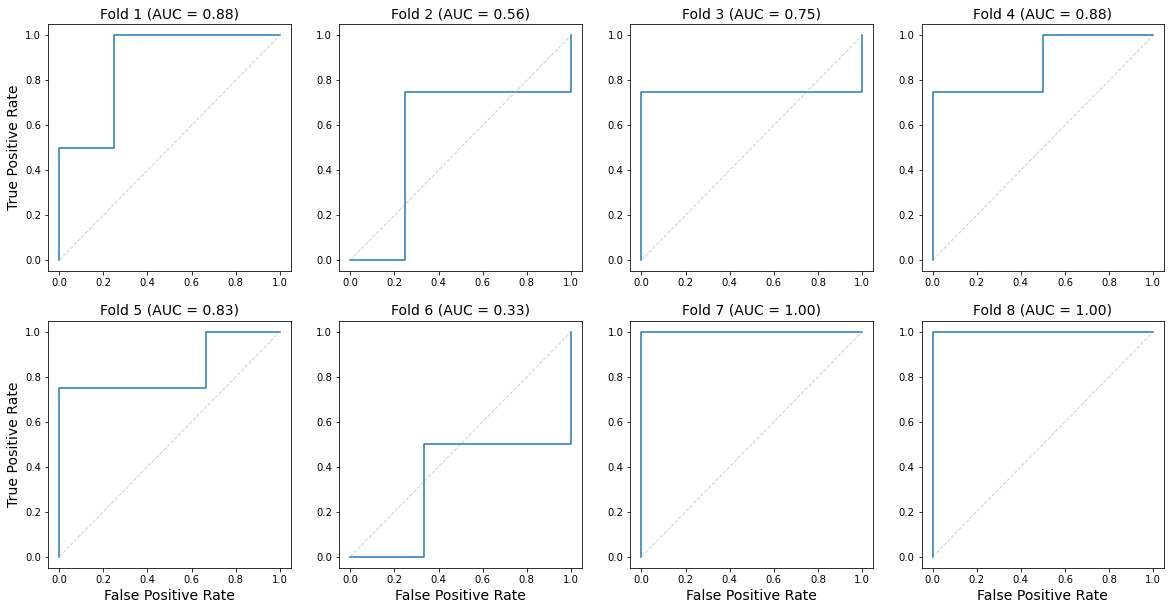

AUC: 	 	 0.78 0.23 	 (mean +- std)
Accuracy: 	 0.85 0.14 	 (mean +- std)
Precision: 	 0.90 0.14 	 (mean +- std)
Recall: 	 0.81 0.18 	 (mean +- std)
F1: 	 	 0.85 0.14 	 (mean +- std)
[[3.125 0.375]
 [0.75  3.125]]


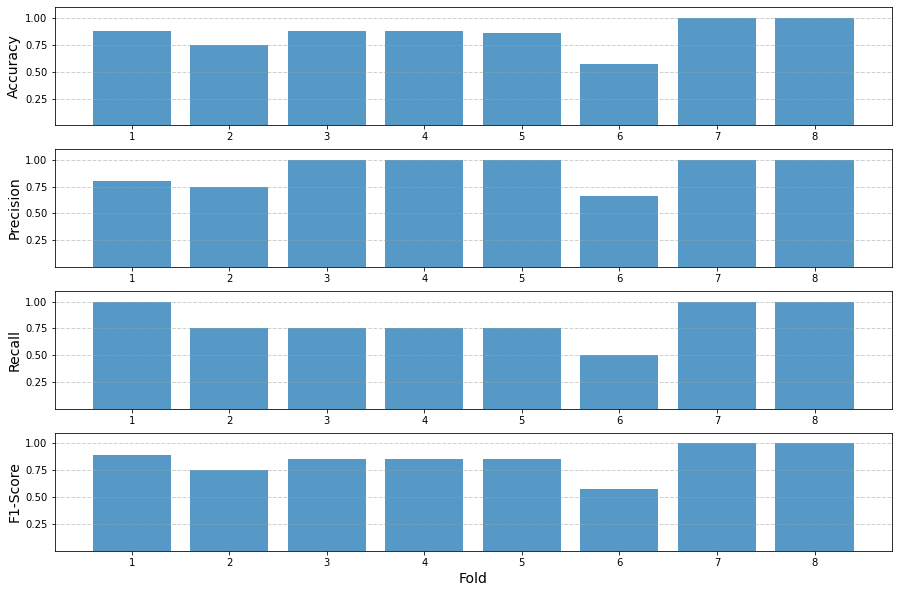

In [78]:
final_combined('4_K-fold_combined','test1')

In [ ]:
final_combined('4_K-fold_combined','test2')

  6%|██▏                                   | 103/1740 [00:00<00:01, 1029.04it/s]

4_K-fold_combined_extraction
Training plots


100%|█████████████████████████████████████| 1740/1740 [00:01<00:00, 1026.71it/s]


Global results
[[3 1]
 [0 4]]
[[4 0]
 [3 1]]
[[4 0]
 [1 3]]
[[4 0]
 [1 3]]
[[3 0]
 [0 4]]
[[3 0]
 [2 2]]
[[3 0]
 [0 4]]
[[3 0]
 [0 3]]


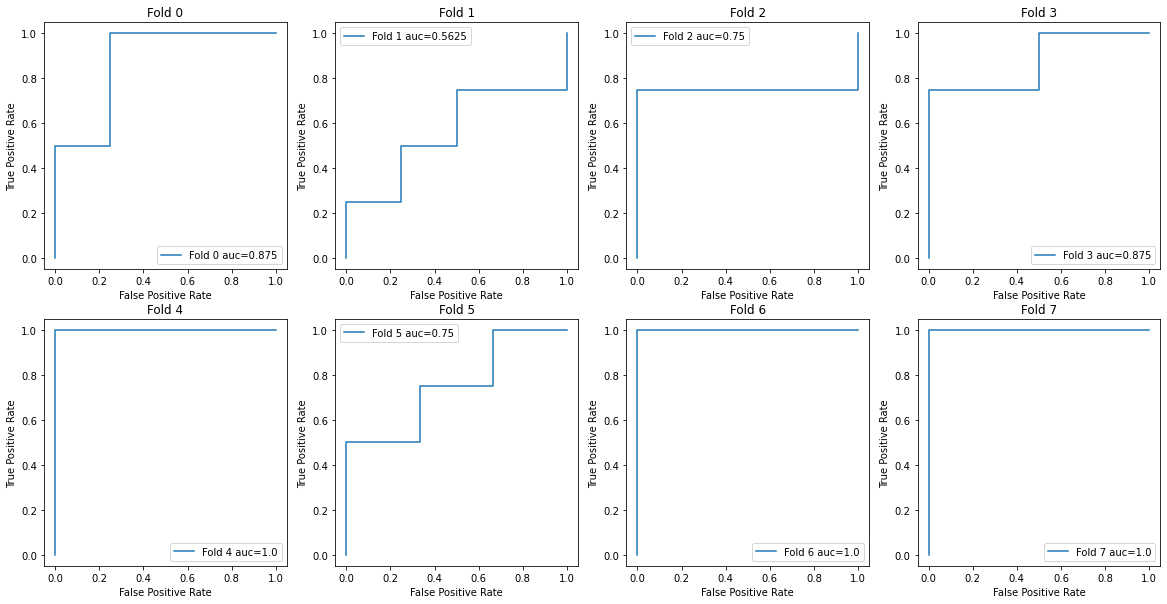

AUC: 	 	 0.85 0.16 	 (mean +- std)
Accuracy: 	 0.87 0.14 	 (mean +- std)
Precision: 	 0.97 0.07 	 (mean +- std)
Recall: 	 0.78 0.28 	 (mean +- std)
F1: 	 	 0.83 0.21 	 (mean +- std)
[[3.375 0.125]
 [0.875 3.   ]]


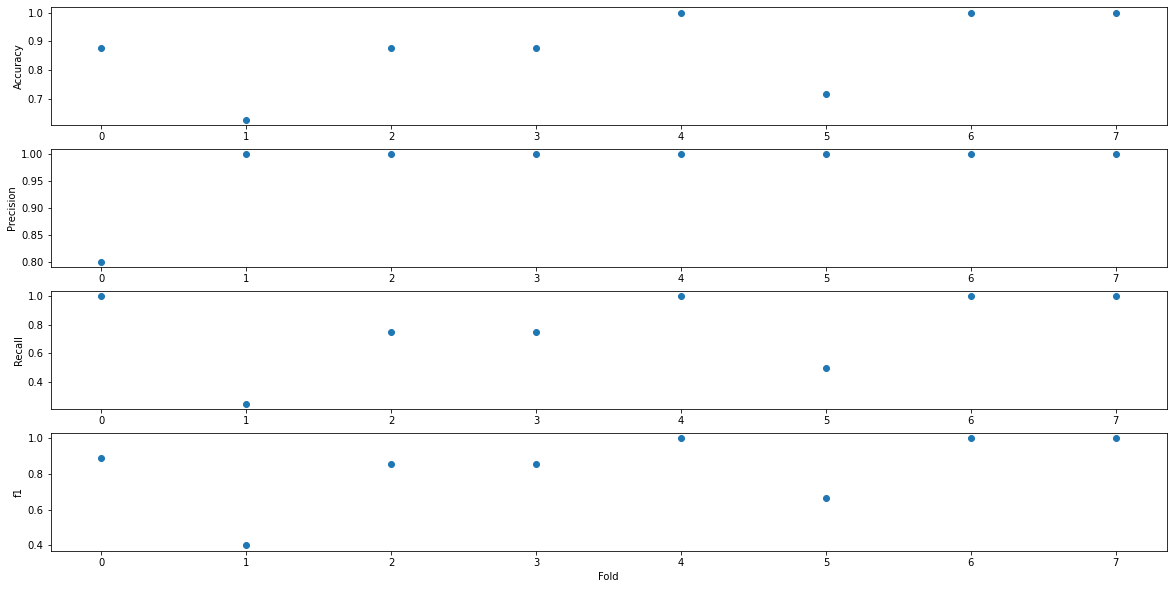

In [64]:
final_combined('4_K-fold_combined_extraction','test1')

  0%|                                                  | 0/1740 [00:00<?, ?it/s]

4_K-fold_combined_extraction
Training plots


100%|█████████████████████████████████████| 1740/1740 [00:01<00:00, 1025.59it/s]


Global results
[[214   0]
 [  0   1]]
[[208   4]
 [  0   1]]
[[210   1]
 [  0   1]]
[[210   0]
 [  0   1]]
[[209   0]
 [  0   1]]
[[208   0]
 [  0   1]]
[[193  15]
 [  0   1]]
[[208   0]
 [  0   1]]


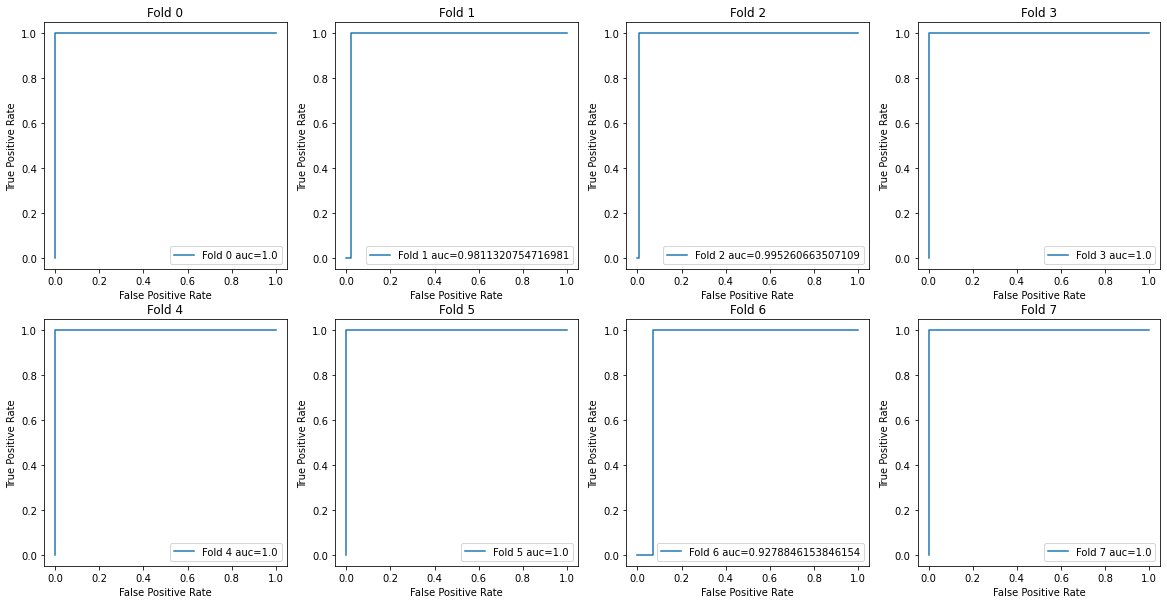

AUC: 	 	 0.99 0.03 	 (mean +- std)
Accuracy: 	 0.99 0.03 	 (mean +- std)
Precision: 	 0.72 0.40 	 (mean +- std)
Recall: 	 1.00 0.00 	 (mean +- std)
F1: 	 	 0.76 0.36 	 (mean +- std)
[[207.5   2.5]
 [  0.    1. ]]


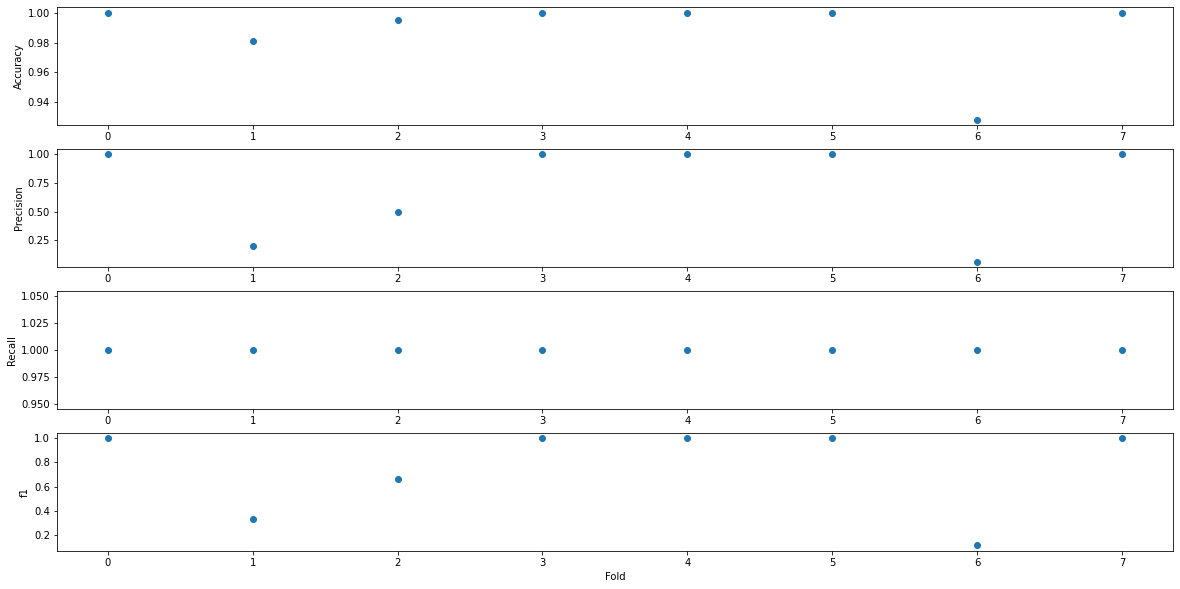

In [65]:
final_combined('4_K-fold_combined_extraction','test2')

4_K-fold_combined_extraction_learning_rate
Training plots


100%|█████████████████████████████████████| 1740/1740 [00:01<00:00, 1019.37it/s]


Global results


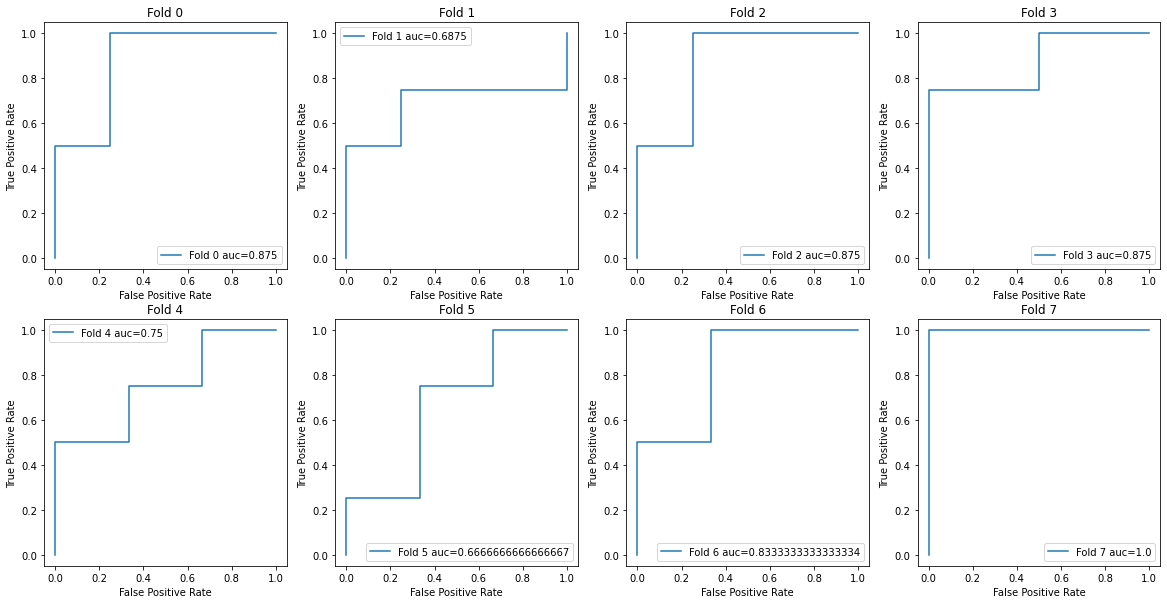

AUC: 	 	 0.82 0.11 	 (mean +- std)
Accuracy: 	 0.83 0.10 	 (mean +- std)
Precision: 	 0.89 0.11 	 (mean +- std)
Recall: 	 0.81 0.22 	 (mean +- std)
F1: 	 	 0.83 0.12 	 (mean +- std)


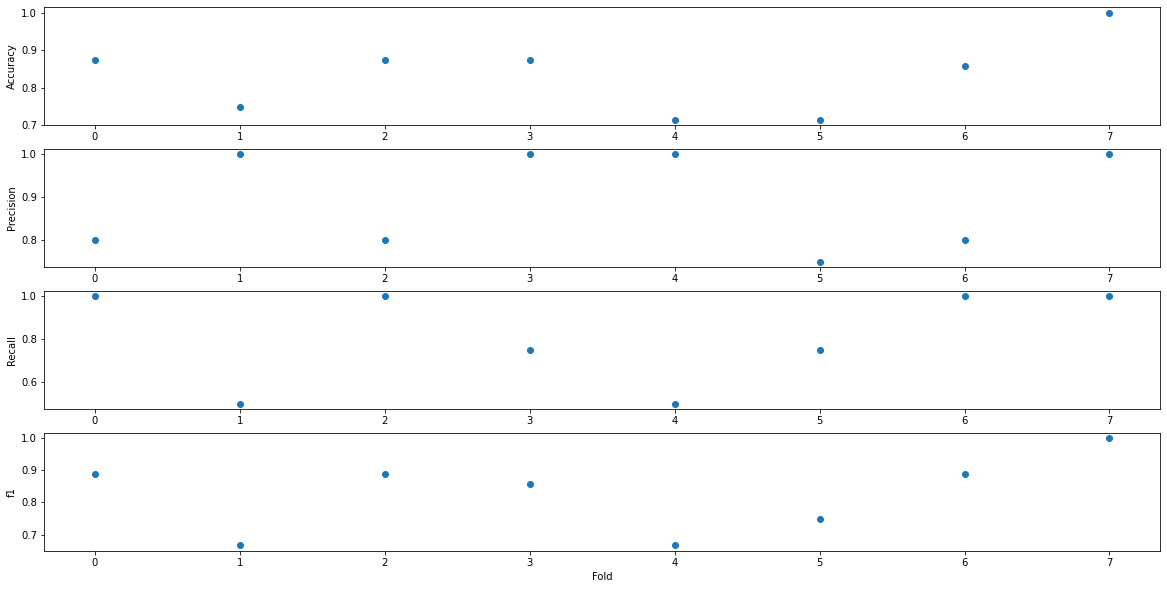

In [49]:
final_combined('4_K-fold_combined_extraction_learning_rate','test1')

  0%|                                                                                     | 0/1291 [00:00<?, ?it/s]

4_K-fold_separated_classification
Training plots


100%|████████████████████████████████████████████████████████████████████████| 1297/1297 [00:01<00:00, 1036.09it/s]


Global results


/home/rjp/Software/anaconda3/envs/optic_chiasm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


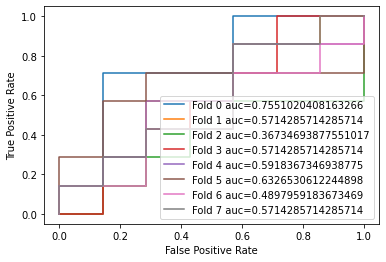

AUC: 	 	 0.57 0.11 	 (mean +- std)
Accuracy: 	 0.58 0.07 	 (mean +- std)
Precision: 	 0.53 0.23 	 (mean +- std)
Recall: 	 0.52 0.25 	 (mean +- std)
F1: 	 	 0.51 0.22 	 (mean +- std)


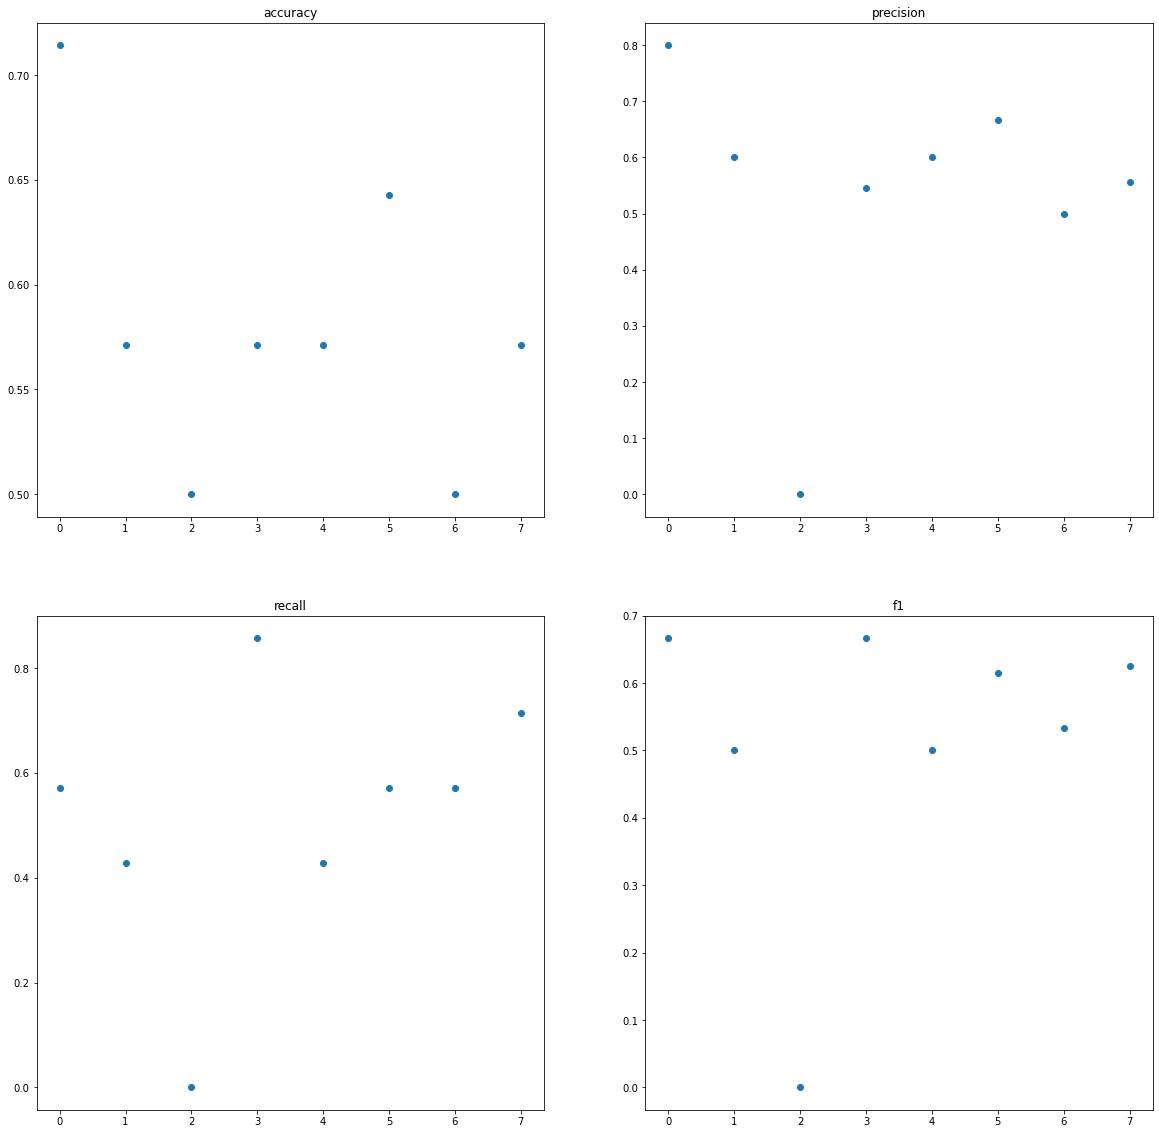

In [18]:
final_separated('4_K-fold_separated_classification','test1')

In [ ]:
final_separated('4_K-fold_separated_classification','test1')

In [ ]:
final_separated('4_K-fold_separated_extraction','test1')

# Performance evaluation

In [ ]:
def evaluate_accuracy(folder_with_networks, dataloader, dataset, group_to_be_evaluated):
    
    criterion = nn.NLLLoss(reduction='sum')
    
    names=[]
    loss=[]
    accuracy=[]
    f1=[]
    precision=[]
    recall=[]
    
    networks = [os.path.basename(x[0]) for x in os.walk(folder_with_networks)]
    networks=networks[1:]
     
    for network in networks:

        # Create network and load the weights
        params=network.split('_')
        
        model = Classifier(int(params[0]),int(params[1]),int(params[2]),int(params[3]), int(params[4]))
        model.load_state_dict(torch.load(folder_with_networks+network+'/optimal_weights'))

        # Evaluate the network on desired dataset
        tmp_loss=0.0
        tmp_targets=[]
        tmp_pred=[]
        
        for batch in dataloader[group_to_be_evaluated]:
            
            data=batch['chiasm']['data']
                        
            with torch.no_grad():
                
                output = model(data)
                
                tmp_loss +=(criterion(output.squeeze(),batch['label']).item())

                tmp_targets+=batch['label'][:].numpy().tolist()
                tmp_pred+=output.round().cpu().detach().numpy().tolist()

        names.append(network)
        loss.append(tmp_loss/len(dataset[group_to_be_evaluated]))
        accuracy.append(accuracy_score(tmp_targets,tmp_pred))
        f1.append(f1_score(tmp_targets,tmp_pred, average='weighted'))
        precision.append(precision_score(tmp_targets,tmp_pred, average='weighted'))
        recall.append(recall_score(tmp_targets,tmp_pred, average='weighted'))
        
    # Return the list with results
    return names,loss,accuracy, f1, precision,recall

In [ ]:
def plot_training(path_to_saved_output):
    
    with open(path_to_saved_output+'train_loss.pkl', 'rb') as f:
        train_loss=pickle.load(f)

    with open(path_to_saved_output+'dev_train_loss.pkl', 'rb') as f:
        dev_train_loss=pickle.load(f)

    with open(path_to_saved_output+'test_loss.pkl', 'rb') as f:
        dev_test_loss=pickle.load(f)

    with open(path_to_saved_output+'train_f1.pkl', 'rb') as f:
        train_f1=pickle.load(f)

    with open(path_to_saved_output+'dev_train_f1.pkl', 'rb') as f:
        dev_train_f1=pickle.load(f)

    with open(path_to_saved_output+'test_f1.pkl', 'rb') as f:
        test_f1=pickle.load(f)
                
    fig = plt.figure(figsize=(20,5))
    plt.suptitle(os.path.basename(path_to_saved_output))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, label='train')
    plt.plot(dev_train_loss, label='train_dev')
    plt.plot(dev_test_loss, label='test')
    plt.legend();
    plt.title('Loss');
    
    plt.subplot(1,2,2)
    plt.plot(train_f1, label='train')
    plt.plot(dev_train_f1, label='train_dev')
    plt.plot(test_f1, label='test')
    plt.legend();
    plt.title('Accuracy');

In [ ]:
def plot_evaluation(names_list, loss_list, acc_list, f1_list, precision_list, recall_list, name):
    
    # order lists
    loss_list, names_list, acc_list, f1_list, precision_list, recall_list = (list(t) for t in zip(*sorted(zip(loss_list, names_list, acc_list, f1_list, precision_list, recall_list))))
    
    # plot with subplots
    fig = plt.figure(figsize=(16,12))
    plt.suptitle(name)
    
    # Cross-entropy loss
    ax1 = plt.subplot(511)
    plt.scatter(names_list, loss_list)
    plt.xticks(rotation=90);
    plt.axhline(y=-0.5, color='r', linestyle='--')
    plt.ylim([-1,0])
    ax1.axes.get_xaxis().set_ticks([])
    plt.title('Losses')
    
    # Accuracy
    ax2 = plt.subplot(512)
    plt.scatter(names_list, acc_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.9, color='r', linestyle='--')
    plt.ylim([-0.05,1.05])
    ax2.axes.get_xaxis().set_ticks([])
    plt.title('Accuracy')
    
    # Precision
    ax2 = plt.subplot(513)
    plt.scatter(names_list, precision_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.9, color='r', linestyle='--')
    plt.ylim([-0.05,1.05])
    ax2.axes.get_xaxis().set_ticks([])
    plt.title('Precision')
    
    # Recall
    ax2 = plt.subplot(514)
    plt.scatter(names_list, recall_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.9, color='r', linestyle='--')
    plt.ylim([-0.05,1.05])
    ax2.axes.get_xaxis().set_ticks([])
    plt.title('Recall')
    
    # F1 score
    ax3 = plt.subplot(515)
    plt.scatter(names_list, f1_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.9, color='r', linestyle='--')
    plt.ylim([-0.05,1.05])
    plt.title('F1-score')

## Training plots

In [ ]:
plot_training('../../1_Data/4_K-fold_combined/2/1_2_2_1_256_1e-05/')

In [ ]:
# Full retraining
#networks=[os.path.basename(f) for f in glob.glob('../../1_Data/3_Trained_classifier_finetuning_classification/*')]
#networks=networks[:-1]

#networks.remove('2_32_1_1_256_1e-06')

#print(networks)

for i in range():
    print(i)
    plot_training('../../1_Data/3_Trained_classifier_finetuning_classification/'+i+'/')
    plt.show()

## Accuracy

In [ ]:
# Full retraining
plot_names, plot_loss, plot_accuracy, f1, precision, recall = evaluate_accuracy('../../1_Data/3_Trained_classifier_finetuning_classification/', dataloaders_chiasm, dict_expl_classifier_training, 'test')
plot_evaluation(plot_names, plot_loss, plot_accuracy, f1, precision, recall, 'Fine tuning classification')

## GradCAM

In [ ]:
def translate_group(index):
    
    if (index==0):
        return 'control'
    elif (index ==1):
        return 'albinism'

In [ ]:
def plot_occlusion(folder_with_networks, dataloader, group_to_be_evaluated, slice_to_be_shown, architectures=None):
    
    if architectures==None:
        networks = [os.path.basename(x[0]) for x in os.walk(folder_with_networks)]
        networks=networks[1:]
    else:
        networks=architectures
    
    # Fetch data used for evaluation
    batch=next(enumerate(dataloader[group_to_be_evaluated]))[1]
    
    for network in networks:#[0:1]:
        
        print(network)
        
        # Initialize the model
        params=network.split('_')

        model = Classifier(int(params[0]),int(params[1]),int(params[2]),int(params[3]),int(params[4]))
        model.load_state_dict(torch.load(folder_with_networks+network+'/optimal_weights'))
        
        # Calculate the accuracy
        prediction = model(batch['chiasm']['data']).squeeze()
        accuracy = accuracy_score(batch['label'],prediction.detach().cpu().numpy().round())
        print(accuracy)
        
        # Plot the explanation provided by occlusion model
        occlusion = Occlusion(model)
        
        plt.figure(figsize=(10,20))
        
        print(batch['chiasm']['data'].shape)
        
        for i in range(len(batch['label'])):
            
            input=batch['chiasm']['data'][i].unsqueeze(0)
                        
            attributions_occ_zero = occlusion.attribute(input,
                                       target=0,
                                       sliding_window_shapes=(1,3,3,1),
                                       baselines=0)
            
            # original image
            plt.subplot(len(batch['label']),2,2*i+1)
            plt.imshow(batch['chiasm']['data'][i:(i+1)][0,0,:,:,3], cmap='gray', alpha=1)    
            plt.ylabel(translate_group(batch['label'][i]))
            plt.tick_params(axis='both', labelsize=0, length = 0)
            
            # explanation for control           
            plt.subplot(len(batch['label']),2,2*i+2)
            plt.imshow(attributions_occ_zero[0,0,:,:,3], cmap='jet', alpha=1)    
            plt.tick_params(axis='both', labelsize=0, length = 0)
            plt.xlabel("{:.2f}".format(prediction[i].item()))
            if(i==0):
                plt.title('Predicted albinism (0-1)')       
                
        plt.show()

In [ ]:
# Full retraining
#plot_gradcam('../../1_Data/3_Trained_classifier_full_retraining/',dataloaders_chiasm,'dev_test',3,['32_1_0_0_1e-06','32_1_1_32_0.0001','32_1_0_0_1e-05'])
# chosen 32_1_0_0_1e-06
plot_occlusion('../../1_Data/3_Trained_classifier_finetuning_classification/',dataloaders_chiasm,'test',3,['2_32_1_1_16_0.001'])

# Performance on averaged data

In [ ]:
# Calculate average input

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))
average_other = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:    
    average_control+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==1], axis=(0,1))
    
average_control /= np.max(average_control)
average_albinism /= np.max(average_albinism)

plt.figure(figsize=(20,20))

for i in range(8):
        
    # Control
    plt.subplot(8,3,3*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average control')
    
    # Albinism
    plt.subplot(8,3,3*i+2)
    plt.imshow(average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average albinism')
        
    # Difference
    plt.subplot(8,3,3*i+3)
    plt.imshow(np.abs(average_control[:,:,i]-average_albinism[:,:,i]), cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference')


In [ ]:
# Calculate average input after AE step

ae = UNet_1_layer(1,1,2,2)
ae.load_state_dict(torch.load('../../1_Data/2_Trained_AE/1_layer_2_2/optimal_weights'))

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))
average_other = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:  
                              
    output = ae(batch['chiasm']['data']).detach().numpy()                
                                                       
    average_control+=np.sum(output[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(output[batch['label'].numpy()==1], axis=(0,1))
    average_other+=np.sum(output[batch['label'].numpy()==2], axis=(0,1))
    
average_control /= np.max(average_control)
average_albinism /= np.max(average_albinism)

plt.figure(figsize=(20,20))

for i in range(8):
        
    # Control
    plt.subplot(8,3,3*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average control')
    
    # Albinism
    plt.subplot(8,3,3*i+2)
    plt.imshow(average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average albinism')
        
    # Difference
    plt.subplot(8,3,3*i+3)
    plt.imshow(np.abs(average_control[:,:,i]-average_albinism[:,:,i]), cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference')


# Explanations with captum

## Showcase on CIFAR

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import visualization as viz

In [ ]:
# Works beautifully!
model = Classifier(1,2,2,1,256)
model.load_state_dict(torch.load('../../1_Data/3_Trained_classifier_finetuning_classification/1_2_2_1_256_1e-05/optimal_weights'))

In [ ]:
for batch in dataloaders_chiasm['test']:
    print('Works')

In [ ]:
# Atribution algorithms on chosen input
ind=0

input = batch['chiasm']['data'][ind].unsqueeze(0)
input.requires_grad = True

In [ ]:
# Set model in evaluation mode
model.eval();

In [ ]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [ ]:
# computes gradients with respect to target class and transposes them for visualization purposes.
saliency = Saliency(model)
grads = saliency.attribute(input, target=labels[ind].item())

In [ ]:
# Applies integrated gradients attribution algorithm on test image. Integrated Gradients computes the integral of the gradients of the output prediction for the class index ind with respect to the input image pixels. More details about integrated gradients can be found in the original paper
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
print('Approximation delta: ', abs(delta))

In [ ]:
# Below we demonstrate how to use integrated gradients and noise tunnel with smoothgrad square option on the test image. Noise tunnel with smoothgrad square option adds gaussian noise with a standard deviation of stdevs=0.2 to the input image nt_samples times, computes the attributions for nt_samples images and returns the mean of the squared attributions across nt_samples images.
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)

In [ ]:
# Applies DeepLift on test image. Deeplift assigns attributions to each input pixel by looking at the differences of output and its reference in terms of the differences of the input from the reference.
dl = DeepLift(model)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)

In [ ]:
fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],5,5*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
    
    plt.subplot(input.shape[4],5,5*i+2)
    plt.imshow(grads.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Grads')
    
    plt.subplot(input.shape[4],5,5*i+3)
    plt.imshow(attr_ig.detach().numpy()[0,0,:,:,i],cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG')
        
    plt.subplot(input.shape[4],5,5*i+4)
    plt.imshow(attr_ig_nt.detach().numpy()[0,0,:,:,i],cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG_NT')
    
    plt.subplot(input.shape[4],5,5*i+5)
    plt.imshow(attr_dl.detach().numpy()[0,0,:,:,i],cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('DL')


## Pretrained ResNet model

In [ ]:
# Integrated gradients
integrated_gradients = IntegratedGradients(model)
attributions_ig_zero = integrated_gradients.attribute(input, target=0, n_steps=200)
attributions_ig_one = integrated_gradients.attribute(input, target=0, n_steps=200)

fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],3,3*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
        
    plt.subplot(input.shape[4],3,3*i+2)
    plt.imshow(attributions_ig_zero.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG 0')
        
    plt.subplot(input.shape[4],3,3*i+3)
    plt.imshow(attributions_ig_one.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG 1')

In [ ]:
# IG + Noise Tunnel
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt_zero = noise_tunnel.attribute(input, nt_samples=20, nt_type='smoothgrad_sq', target=0)
attributions_ig_nt_one = noise_tunnel.attribute(input, nt_samples=20, nt_type='smoothgrad_sq', target=0)

fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],3,3*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
        
    plt.subplot(input.shape[4],3,3*i+2)
    plt.imshow(attributions_ig_nt_zero.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG NT 0')
        
    plt.subplot(input.shape[4],3,3*i+3)
    plt.imshow(attributions_ig_nt_one.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG NT 1')

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs_zero = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=0)

attributions_gs_one = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=0)

fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],3,3*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
        
    plt.subplot(input.shape[4],3,3*i+2)
    plt.imshow(attributions_gs_zero.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('SHAP 0')
        
    plt.subplot(input.shape[4],3,3*i+3)
    plt.imshow(attributions_gs_one.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('SHAP 1')

In [ ]:
# Occlusion
occlusion = Occlusion(model)

attributions_occ_zero = occlusion.attribute(input,
                                       target=0,
                                       sliding_window_shapes=(1,2,2,1),
                                       baselines=0)


attributions_occ_one = occlusion.attribute(input,
                                       target=0,
                                       sliding_window_shapes=(1,2,2,1),
                                       baselines=0)

In [ ]:
fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],4,4*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
                
    plt.subplot(input.shape[4],3,3*i+2)
    plt.imshow(attributions_occ_zero.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Occlusion 0')
        
    plt.subplot(input.shape[4],3,3*i+3)
    plt.imshow(attributions_occ_one.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Occlusion 1')